### This is a jupyter notebook to show some of the preprocessing steps of Counting of hajis
<br>
Image Preprocessing involves cleaning the image, removing unwanted noise through mathematical models and reducing the dimensions of the data. In this notebook, I take you through converting the given hajj image to grayscale, finding out the magnitude of the gradient and also finding out the threshold for binarizing the image.

In [1]:
from skimage import io
from skimage import color
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

%matplotlib inline

In [2]:
from skimage.filters import threshold_otsu

#### Read and display the image in RGB and Grayscale

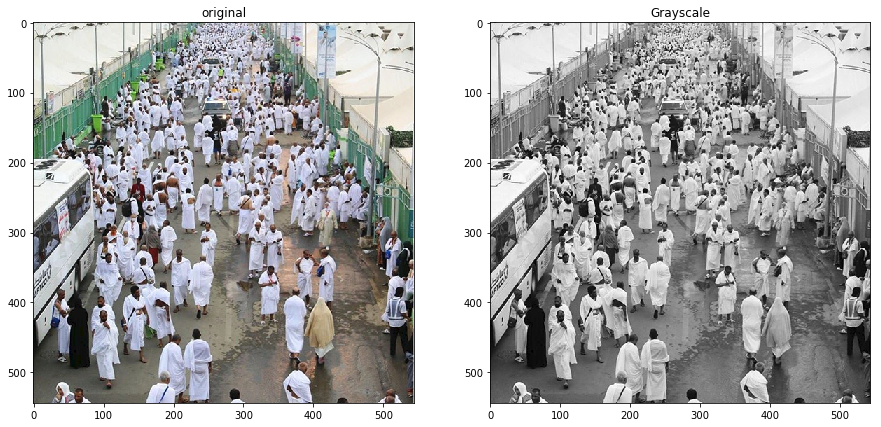

In [3]:
hajj_img = io.imread("mina_street.png")
hajj_img_gray = color.rgb2gray(hajj_img)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('original')
plt.imshow(hajj_img)
plt.subplot(122)
plt.imshow(hajj_img_gray,'gray')
plt.title('Grayscale')
plt.show()

#### Create a Mean kernel to convolve over the given image to find the ideal threshold using Sauvola algorithm <br>
This is my own implementation of the Sauvola algorithm. It's theoretical details can be found here<br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.98.880&rep=rep1&type=pdf

It is based on the equation $$\mathbf{T} = \mathbf{M}\left(1 +\ k\times\left(\frac{\mathbf{S}}{\mathbf{R}} -\ 1\right)\right)$$

<br>
Where **T** is the Threshold <br>
**M** is the Mean of the kernel<br>
**_k_** is the co-efficient of thickness<br>
**S** is the Standard deviation <br>
**R** is the Range of values in the kernel<br>

In [4]:
def get_mean_kernel(shape):
    kernel = np.ones((shape[0],shape[1]), np.float32)
    kernel = kernel/np.sum(kernel)
    return kernel

mean_kernel = get_mean_kernel((20,20))

def thariq_sauvola(gim, mean_kernel, k = 0.1):
    im2 = gim**2
    expI = convolve(gim, mean_kernel, mode='same')
    expI2 = convolve(im2, mean_kernel, mode='same')

    S = np.sqrt(expI2 - np.square(expI) + 1e-8)
    R = gim.max() - gim.min()
    
    M = convolve(gim, mean_kernel, mode='same')
    
    T = M*(1 + k*((S/R) - 1))
    
    sauvola_im = gim < T
    return sauvola_im

#### Custom function to display 2 images together

In [5]:
def display_images(img1,img2,img1_title,img2_title):
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.title(img1_title)
    plt.imshow(img1)
    plt.subplot(122)
    plt.title(img2_title)
    plt.imshow(img2)
    plt.gray()
    plt.show()

#### The gradients are found as the first step to find the segmentation boundaries. <br>
Ideally this is what the first layer of a Deep Neural Network does. Here I have demonstrated it by finding out the gradients along the X and Y axes so as to give the idea of how it happens. Different methods can be deployed to find out the gradients. Here it is just the grdient magnitude that is calculated.

In order to demonstrate the gradient finding with Neural Network, we require huge data.
<br>
Gradient magnitude is given by

\begin{align}
    gmag = \sqrt{\left(\frac{\partial\mathbf{I}}{\partial\mathbf{x}}\right)^2 +\ \left(\frac{\partial\mathbf{I}}{\partial\mathbf{y}}\right)^2}
\end{align}
<br>
Where **I** is the Image, **x** and **y** are the co-ordinate axes

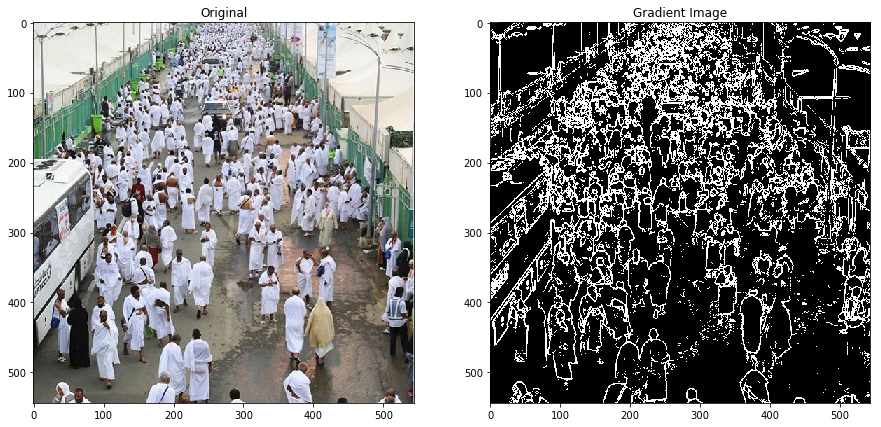

In [6]:
gy, gx = np.gradient(hajj_img_gray)
gmag = np.sqrt(gx**2 + gy**2)
grad_im = gmag > 0.1
#display the images for comparison
display_images(hajj_img,grad_im,img1_title='Original',img2_title='Gradient Image')

#### Thresholding
A threshold is found so as to binarize an image. In this problem it will help in finding out the dark condensed patches
which would denote the locations of heads of people

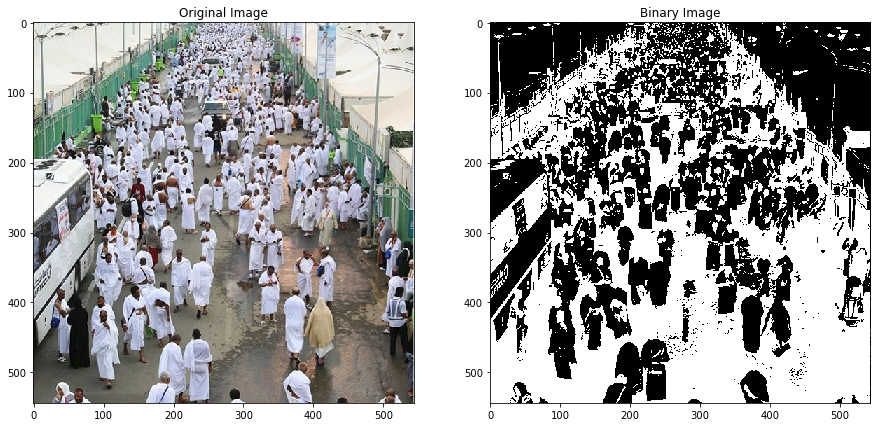

In [10]:
thresholded_im = hajj_img_gray < threshold_otsu(hajj_img_gray)#,mean_kernel)
#display the images for comparison
display_images(hajj_img, thresholded_im, img1_title='Original Image',
               img2_title='Binary Image')

obj_count = 2419


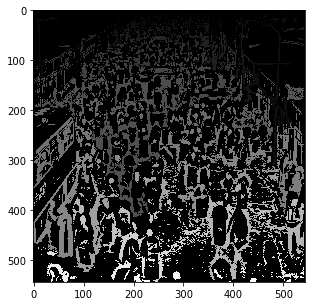

In [22]:
#function to find out the connected components and then find the heads
label_img, obj_count = ndimage.label(thresholded_im)

print "obj_count =",obj_count

plt.figure(figsize=(5,5))
plt.imshow(label_img,'gray')
plt.show()

The connected components algorithm was giving the count as 2601 out of which majority of it attributes to the noise and objects in the background (like tent, bus, street light poles, etc..). In practical situations, when the camera is fixed so as to assist the vision algorithms, the street co-ordinates are also fixed and the regions of interest for counting can be extracted out which helps in removing these noises to a great extent.<br>

## Caveat:
**Positioning of the camera is one of the most crucial steps in the design of the solution to the problem. The way the cameras are positioned helps the machine learning scientist in reducing the number of models  and computations required. It also helps in finding out agnostic solutions for multiple locations of the mounted cameras (ex:- mina street and jamarat)**<br>

**It is difficult even for the human eye to count the number of people in the above image to measure the ground truth**. <br>
Important point to be noted in the real scenario is that heads need to be counted as and when they go through a specific portion in the near sight of the camera (ex:- the bottom 1/3rd or 2/5th of the image). I’ve used this observation to calculate the ground truth = 24 as shown below

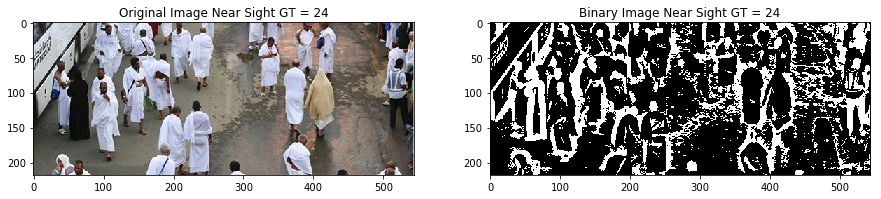

In [23]:
interest_region = 0.60
height_slice = int(hajj_img_gray.shape[0]*interest_region)
# Get only the bottom 40% of the image to find out the head counts
count_bin_im = thresholded_im[height_slice:,]
orig_slice_im = hajj_img[height_slice:,]
#display the region of interest for counting using the camera near sight
display_images(orig_slice_im, count_bin_im, img1_title='Original Image Near Sight GT = 24',
               img2_title='Binary Image Near Sight GT = 24')

Let's do the simple connected components based object count again!

In [32]:
def blurnDenoise(bw,sz=(5,5),sigma=2,thresh=0.3, sum_thresh=30):
    I = bw.astype(float)
    fg = cv2.GaussianBlur(I,sz,sigma)
    m1 = fg > thresh
    labels,num_items = ndimage.label(m1,np.ones((3,3),'int'))
    pixel_sum = ndimage.sum(m1, labels, range(num_items+1)).astype(np.int)
    mask_size = pixel_sum < sum_thresh
    remove_pixel = mask_size[labels]
    m1[remove_pixel] = 0
    return m1

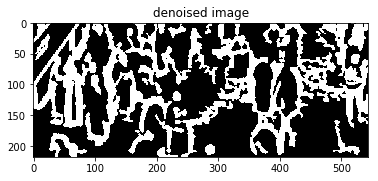

In [51]:
orig_im = count_bin_im
denoised_im = blurnDenoise(orig_im,sum_thresh=120)
plt.title('denoised image')
plt.imshow(denoised_im,'gray')
plt.show()

In [52]:
_, count = ndimage.label(denoised_im)
print "Objects count =", count
print "Ground Truth = 24"

Objects count = 27
Ground Truth = 24


The above is only one way. Here the Street noises and bus boundaries have come into the picture adding to the number
of objects above the Ground truth.

### TODO:
* Create circular mask to detect the heads properly
* Remove the street noise by identifying the histogram of the streets